The goal of this notebook is to write code that given a specific nucleus to produce, an efficiency will be calculated based on the required input energy, target cross sections, and power density of the product to find the optimal use of radionuclide production as a method of energy storage. 

This can also be used to generate a theoretical maximum of storage efficiency for each product. 

To start, we'll need cross sections. 

Will attempt to download the entirety of (or write a very fast query for) 
https://doi.org/10.1016/j.nds.2018.02.001

Pivoting to use Jeff32 since it has a singular directory with many neutron cross sections for different targets. https://www.oecd-nea.org/dbforms/data/eva/evatapes/jeff_32/

JENDL appears to have both neutron and proton cross section data for transmutation, so this seems very promising. It uses the ENDF6 format https://www-nds.iaea.org/public/endf/ 

Finally found the database explorer for ENDF, will be using this as well. 
https://www-nds.iaea.org/exfor/e4explorer.htm 

Found the Readme files for the two part ENDF libraries I downloaded: 

file:///C:/Users/engin/Downloads/ENDF_Libraries/ENDF_Libraries/readme.htm 

file:///C:/Users/engin/Downloads/ENDF_Libraries-2/ENDF_Libraries-2/readme-2.htm

#Derivations for nuclide production
Consider a thin target $T$ with a cross section $\sigma$ at an energy level of $E_{particle}$. We have for the production rate (from "Industrial Accelerators and their Applications")
\begin{equation}
\frac{dR}{dx} = In\sigma
\end{equation}
Integrating, we have for the number of nuclei produced
\begin{equation}
N = \int\int\frac{dR}{dx}dxdt = \int\int In\sigma dxdt
\end{equation}
Where $R$ is the production rate in atoms per second, $x$ is the depth of the material, $n$ is the nuclei/volume, and $\sigma$ is the cross section in area/nucleus, and $I$ is the flow rate in moles/second of the beam. It's also important to note that the beam energy is also a function of $x$. Thus we have for the energy input 
\begin{equation}
E_{in} = \int IE_{incident \ particle} dt
\end{equation}
For a given decay chain whose parent nucleus has $N$ particles we have for a pure amount of this substance a specific energy (energy density) $\rho_{E}$ of 
\begin{equation}
E_{out} = Z_{product}N\rho_{E}
\end{equation}
where $Z$ is the mass number of the product and $N_A$ is Avogadro's constant. 
Thus we have for the energy efficiency of this process, 
\begin{equation}
\frac{E_{out}}{E_{in}} = \frac{Z_{product}N\rho_{E}}{\int IE_{incident \ particle} dt} =  
\frac{Z_{product}\rho_{E}\int\int In\sigma dxdt}{\int IE_{incident \ particle} dt}
\end{equation}

##Thin target case with constant beam current and energy
\begin{equation}
\frac{E_{out}}{E_{in}} = \frac{Z_{product}\rho_{E} In\sigma xt}{IE_{incident \ particle}t} = \frac{Z\rho_{E} n\sigma x}{E_{incident \ particle}}
\end{equation}
Rearranging to find the energy efficiency per thickness of material 
\begin{equation}
\frac{E_{out}}{xE_{in}} = \frac{Z_{product}\rho_{E} n\sigma }{E_{incident \ particle}}
\end{equation}
Thus, our figure of merit for a reaction will be energy efficiency per thickness of material. 


#Now I will find the probability of a given reaction for a thick target (on the order of meters). 

Where $P$ is the probability of a specific nuclear reaction occuring (e.g. aborbing a gamma ray and ejecting a neutron), $r$ is the reaction cross section, $x$ is the thickness of the target in meters, $t$ is the total cross section ($t>r>0$) and $a$ is the cross section of all reactions that are mutually exclusive with the reaction associated with $r$. We define $k$
 
\begin{equation}
\begin{split}
k = \frac{-\rho N_A}{M}
\end{split}
\end{equation}
 
Where $\rho$ is the mass density in kg/m $^3$, $M$ is the molar mass in kg, and $N_A$ is Avogadro's number.
Note that I have not yet accounted for other reactions included in the total cross section that would prevent a different reaction. 
Are there any reactions that would prevent a given different reaction? If so, which?

Where the reaction cross section is $a$ and the total cross section is $t$ we have

In [1]:
#This cell requires a sage Jupyter server. https://www.sagemath.org/
from IPython.display import Markdown as md
import sympy
#https://stackoverflow.com/questions/18878083/can-i-use-variables-on-an-ipython-notebook-markup-cell
x, k, t, r, d, a, b = var('x k t r d a b', domain = 'positive')
#k = var('k', domain = 'real')
#what is the probability that the reaction doesn't happen?
#probability of another reaction or no reaction
another_reaction = 1-exp(a*k*x)
no_reaction = exp(t*k*x)
reaction_doesnt_happen = no_reaction + another_reaction 
#These events are mutually exclusive!!
reaction = 1 - reaction_doesnt_happen
d = diff(reaction, x)
x_max = sympy.solve(d == 0, x)[0]._sage_() #convert from sympy object
reaction_max = reaction.substitute(x = x_max)#.full_simplify()
md("\\begin{split}"+
"\\Large P = 1-(%s+%s)=%s"%(latex(no_reaction),latex(another_reaction),latex(reaction))+
"\\\\"+ "\\Large \\frac{dP}{dx} = %s"%(latex(d))+ "\\\\"
"\\Large x_{p_{max}} = %s"%latex(x_max)+ "\\\\" +
"\\Large P_{max} = %s"%latex(reaction_max)+
"\\end{split}")

\begin{split}\Large P = 1-(e^{\left(k t x\right)}+-e^{\left(a k x\right)} + 1)=e^{\left(a k x\right)} - e^{\left(k t x\right)}\\\Large \frac{dP}{dx} = a k e^{\left(a k x\right)} - k t e^{\left(k t x\right)}\\\Large x_{p_{max}} = \frac{\log\left(\frac{t}{a}\right)}{{\left(a - t\right)} k}\\\Large P_{max} = \left(\frac{t}{a}\right)^{\frac{a}{a - t}} - \left(\frac{t}{a}\right)^{\frac{t}{a - t}}\end{split}

The order of magnitude estimates for the cross sections listed look promising!

Now I will convert each cross sections data file into a dictionary where the keys are the MTs and the values are a dataframe (or 2d array) of cross section vs energy. 

Interestingly, the maximum probability of the reaction occuring appears to only depend on the total cross section, $t$, and the cross sections for reactions that are mutually exclusive with a given reaction, $a$. However, the corresponding target thickness does also depend on the target's molar mass and density.

If none of the other reactions are mutually exclusive with a given reaction with a cross section $r$, then we instead have

In [2]:
reaction = 1 - exp(k*r*x)
md("\\begin{split}\\Large P = %s\\end{split}"%latex(reaction))

\begin{split}\Large P = -e^{\left(k r x\right)} + 1\end{split}

Which agrees with Section 2.5.1 of "The Physics of Nucear Reactors". 

Now I will plot $P_{max}$ and $x_{max}$ for neutron ejection as a function of the energy of an incoming gamma ray striking a deuterium target. 

If none of the other possible reactions are mutually exclusive with the reaction associated with a given reaction with cross section $r$ then we instead have

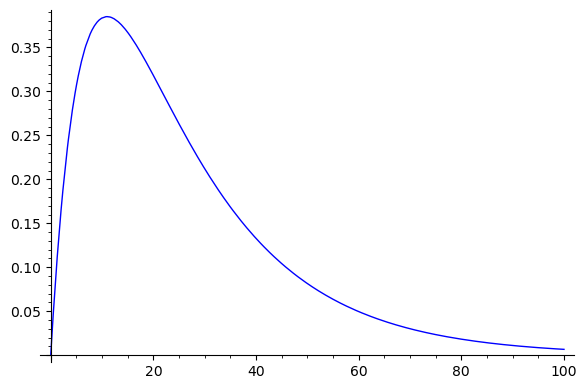

In [3]:
t = .1
k = -1
r = t / 2
another_reaction = 1-exp((t-r)*k*x)
#are cross sections additive?
no_reaction = exp(t*k*x)
reaction_doesnt_happen = no_reaction + another_reaction - (another_reaction*no_reaction)
reaction = 1- reaction_doesnt_happen
plot(reaction, (x, 0, 100))

From Section 2.5.1 of "The Physics of Nucear Reactors" we have for the probability of reaction for a path length $x$ with target with nuclear cross section $\sigma$, molar mass in kg $M$, and mass density in kg/m $^3$ $\rho$, and $A$ is Avogadro's number.
\begin{equation}
\begin{split}
P = (1-e^{krx})e^{(a-r)kx}\\
\end{split}
\end{equation}

In [1]:
import ENDF6
import glob
import plotly.express as px
import numpy as np
import pandas as pd
gamma_path = "C:\\Cross-Section-Data\\jendl5-g"
File_list = sorted(glob.glob(gamma_path + "\\*.dat"))
densities_path = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData\\Periodic Table of Elements.csv"
#open csv as dataframe
densities_df = pd.read_csv(densities_path)
def find_min_reaction_energy(file):
    with open(file):
        try:  
            sec = ENDF6.find_section(open(file).readlines(), MF=3, MT=5)  # relevant cross section 
        except:
            sec = ENDF6.find_section(open(file).readlines(), MF=3, MT=50)  # relevant cross section
        x, y = ENDF6.read_table(sec)
        element_name = file[37:39].replace("-", "")
        #get index of element
        element_index = densities_df.index[densities_df["Symbol"] == element_name][0]
        #get density of element
        density = 1000 * densities_df["Density"][element_index] #kg/m^3
        N_A = 6.02214086e23 #Avogadro's number
        M = 2 #g/mol
        k = -density * N_A / M
        P = 1-np.exp(k * y * 10**-28 * 1000)
        #average power of 10 of energy in eV per reaction
        return np.log10(min(x/P))

gamma_reaction_energy_dict = {}
gamma_reaction_energy_dict["Isotope"] = [file[37:-3].replace(".", "") for file in File_list]
gamma_reaction_energy_dict["log base 10 of Minimum Energy in eV per Reaction"] = [
        find_min_reaction_energy(file) for file in File_list]
gamma_reaction_energy_df = pd.DataFrame(gamma_reaction_energy_dict)
print("minimum energy per reaction in dataset", min(gamma_reaction_energy_df[
    "log base 10 of Minimum Energy in eV per Reaction"].to_list()))
px.scatter(gamma_reaction_energy_df, x = "Isotope", 
            y = "log base 10 of Minimum Energy in eV per Reaction")
#px.scatter(x=x, y=y, labels = {'x':"Photon energy [eV]", 'y' : "Cross-section [barn]"},
#log_x = True, log_y = True)

ArgumentError: ArgumentError: Package ENDF6 not found in current path:
- Run `import Pkg; Pkg.add("ENDF6")` to install the ENDF6 package.


Which isn't bad considering the energy per 228Ra nucleus > 10 $^{6.5428234}$
How much energy does it actually take to produce 1 nucleus of 228Ra?

In [2]:
#Need to unzip files in multiple directories, so I'll do that here with Python 
import zipfile
import os
import glob
def unzip(directory, file_name):
    with zipfile.ZipFile(directory + file_name, 'r') as zip_ref:
        zip_ref.extractall(directory)
def list_subfolders_with_paths(path):
    return [f.path for f in os.scandir(path) if f.is_dir()]
def is_unzipped(zip_file, unzip_types = [".dat", ".endf", ".endf6" ".txt"]):
    return any([os.path.exists(zip_file[:-4] + unzip_type) for unzip_type in unzip_types])

ArgumentError: ArgumentError: Package zipfile not found in current path:
- Run `import Pkg; Pkg.add("zipfile")` to install the zipfile package.


In [3]:
subdirs_1 = list_subfolders_with_paths("C:\\Cross-Section-Data\\ENDF_Libraries\\")
subdirs_2 = list_subfolders_with_paths("C:\\Cross-Section-Data\\ENDF_Libraries-2\\")
#list all the zip files in subdirectories in two 1-d arrays.
zip_files_1 = sum([glob.glob(subdir + "\\**\\*.zip") for subdir in subdirs_1], [])
zip_files_2 =  sum([glob.glob(subdir + "\\**\\*.zip") for subdir in subdirs_2], [])
#filter out the ones that are already unzipped
zip_files_1 = [zip_file for zip_file in zip_files_1 if not is_unzipped(zip_file)]
zip_files_2 = [zip_file for zip_file in zip_files_2 if not is_unzipped(zip_file)]

UndefVarError: UndefVarError: list_subfolders_with_paths not defined

In [4]:
for path in zip_files_1:
    dir_end_index = path.rindex("\\")+1
    directory = path[:dir_end_index]
    file_name = path[dir_end_index:]
    unzip(directory, file_name)
for path in zip_files_2:
    dir_end_index = path.rindex("\\")+1
    directory = path[:dir_end_index]
    file_name = path[dir_end_index:]
    unzip(directory, file_name)


ErrorException: syntax: line break in ":" expression

In [5]:
all(is_unzipped(zip_file) for zip_file in zip_files_1)

UndefVarError: UndefVarError: zip_files_1 not defined

In [6]:
all(is_unzipped(zip_file) for zip_file in zip_files_2)

UndefVarError: UndefVarError: zip_files_2 not defined

#Switching to Julia
I'll be dealing with a lot of data and computations so I'll use Julia instead of Python. 

In [1]:
using Unitful #https://painterqubits.github.io/Unitful.jl/stable/
#quantity * @u_str("unit abbreviation") 
using Symbolics #https://symbolics.juliasymbolics.org/dev/
#cite https://doi.org/10.48550/arXiv.2105.03949
using Latexify
using Test
#1 * @u_str("mA") is 1 milliamp
using CSV, DataFrames
#using Plots
using PlotlyJS
using Printf
using SymPy
using PDFIO
using Unzip
#plotlyjs()
data_dir = ("C:\\Cross-Section-Data\\")
cross_section_dir = data_dir
import_data_dir = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData"

#https://docs.juliahub.com/SymPy/ 
P, N, x, Σ, σR, σT, ρ, M, A = symbols("P, N, x, Σ, σ_R, σ_T, ρ, M, A", positive = true, real = true)
N = ρ * A/ M
Σ = N * σR  
#case without competing reactions
P = integrate(Σ*exp(-Σ*x), (x, 0, x))

#julia implementation of the case with competing reactions
P_max(t,a) = (t/a)^(a/(BigFloat(a)-BigFloat(t))) - (t/a)^(t/(BigFloat(a)-BigFloat(t)))
x_max(t,a,k) = (log(t/a))/(k*(BigFloat(a)-BigFloat(t)))
t = BigFloat(10)^-28
n = 6
a = t * (10^n - 1)/(10^n)
k = -BigFloat(10)^24
x_max(t,a,k)
P_max(t, a)

3.678796251112702055560036812740509330698235054484455628233880381639802135001537e-07

Here we define a dictionary that matches each value of MT in an ENDF6-formatted data to a particular reaction. 

We then will also loop through all of the subdirectories in a directory, then unzip all of the compressed files to that directory that don't already have an unzipped counterpart in that directory.

In this notation $(z, 2nd)$ refers to a reaction where some matter strikes a target and produces 2 neutrons, a deuteron, and a residual.

Furthermore, "(z, n ^3He)" refers the production of a neutron, a Helium-nucleus, and a residual. 

Subscripts refer to the energy state.

(z, $\gamma$) refers to radiative capture
The below code assumes that the complete reaction is in the same line as the MT number. 

Luckily the only time a subscript could be confused with a coefficient is the case of $^3$ He but from just reading the original PDF, it is clear that He never has a coefficient other than 1, and that seeing "3 He" in the text file always refers to a helium-3 nucleus. 

The function matches_pattern returns whether or not a given section of the txt file defines an MT value and the number of digits in the MT value. Conveniently, a subscript is never followed by a character and is always after the nucleus it describes the energy level of.

In [2]:
# import text file as string with Julia
mt_path = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData\\mt.txt"
function matches_pattern(long_string, index = 1)
    if isdigit(long_string[index]) && occursin(",", long_string)
        if  isdigit(long_string[index+1])
            if isdigit(long_string[index+2])
                #3 digit number
                return (long_string[index+3:index+4] == " (", 3)  
            elseif long_string[index+2] == ' ' 
                #two digit number 
                return (long_string[index+3] == '(', 2)
            end
        elseif long_string[index+1] == ' ' 
            #one digit number 
            return (long_string[index+2] == '(', 1)
        end
    end
    return (false, 0)
end
function define_MTs(mt_path)
    open(mt_path) do file
        mt_reactions, mt_details = Dict([]), Dict([])
        long_string = read(mt_path, String)
        index = 0
        print(index)
        while true
            index += 1
            if (index > length(long_string) - 12)
                return mt_reactions, mt_details
            end
            is_MT, MT_length = matches_pattern(long_string[index:index+6])
            if is_MT
                try
                    MT = parse(Int64, long_string[index:index+MT_length])
                    reaction_end = collect(findfirst(")", long_string[index:end]))[1] + index
                    reaction = strip(long_string[index+MT_length+1: reaction_end])
                    if !(reaction == "(Unassigned)")
                        println(MT, reaction)
                        mt_reactions[MT] = reaction
                        #now to get the details
                        details_end = collect(findfirst(".\r", long_string[reaction_end+1:end]))[1] 
                        details_end += reaction_end + 1
                        details = strip(long_string[reaction_end+1: details_end])
                    details = replace(details, "\r" => " " )
                        details = replace(details, "\n" => "" )
                        mt_details[MT] = details
                        index = details_end
                    else
                        index = reaction_end                     
                    end
                catch
                    println(index)
                end
            end
        end 
    end
end
mt_reactions, mt_details = define_MTs(mt_path)
CSV.write("C:\\Users\\engin\\Documents\\GitHub\\Energy\\mt_reactions.csv", mt_reactions)
CSV.write("C:\\Users\\engin\\Documents\\GitHub\\Energy\\mt_details.csv", mt_details)

02(z,z0)
4(z,n)
10(z,contin.)
11(z,2nd)
16(z,2n)
17(z,3n)
19(n,f)
20(n,nf)
21(n,2nf)
22(z,nα)
23(n,n3α)
24(z,2nα)
25(z,3nα)
27(n,abs)
28(z,np)
29(z,n2α)
30(z,2n2α)
32(z,nd)
33(z,nt)
34(z,n3He)
35(z,nd2α)
36(z,nt2α)
37(z,4n)
38(n,3nf)
41(z,2np)
42(z,3np)
44(z,n2p)
45(z,npα)
50(y,n0)
51(z,n1)
52(z,n2)
90(z,n40)
91(z,nc)
102(z,γ)
103(z,p)
104(z,d)
105(z,t)
106(z,3He)
107(z,α)
108(z,2α)
109(z,3α)
111(z,2p)
112(z,pα)
113(z,t2α)
114(z,d2α)
115(z,pd)
116(z,pt)
117(z,dα)
151(n,RES)
152(z,5n)
202(z,Xγ)
203(z,Xp)
204(z,Xd)
205(z,Xt)
206(z,X3He)
207(z,Xα)
208(z,Xπ+)
209(z,Xπ0)
210(z,Xπ−)
211(z,Xμ+)
212(z,Xμ−)
213(z,Xκ+)
214(z,Xκ0 long )
215(z,Xκ0 short)
216(z,Xκ−)
217(z,Xp−)
218(z,Xn−)
251(n,...)
252(n,...)
253(n,...)
450(z,...)
451(z,...)
452(z,...)
454(z,...)
455(z,...)
456(z,...)
457(z,...)
458(n,...)
459(z,...)
460(z,...)
600(z,p0)
601(z,p1)
602(z,p2)
603(z,p3)
604(z,p4)
649(z,pc)
650(z,d0)
651(z,d1)
652(z,d2)
699(z,dc)
700(z,t0)
701(z,t1)
702(z,t2)
749(z,tc)
750(n,3He0)
751(n,3He1)
799(n,3He

"C:\\Users\\engin\\Documents\\GitHub\\Energy\\mt_details.csv"

Now to filter the reactions for those that are sufficiently explicit.
I use the convention where all nuclei are represented in the form (z,a) and 

reaction + target = product

In [3]:
MTs = [key for key in keys(mt_reactions)]
reactions = [value for value in values(mt_reactions)]
symbol_dict = Dict([
            ("n", (0, 1)),
            ("t", (1, 3)), #2 neutrons, 1 proton
            ("d", (1, 2)),
            ("p", (1, 1)),
            ("α", (2, 4)),
            ("γ", (0, 0)),
            ("3 He", (2, 3)),
            ('c', (0,0)) #reverse to continuum emission
        ])
reaction_symbols = [key for key in keys(symbol_dict)]

function find_difference(term, projectile = (0,0))
    #e.g. term = "n"
    difference = (0, 0) #(Z, A)
    if occursin("z", term)
        difference = (projectile[1], projectile[2])
    end
    #now to search for instance of any of the keys in term
    for key in reaction_symbols
        if occursin(key, term)
            sub_difference = (0, 0)
            key_index = collect(findfirst(key, term))[1]
            sub_difference = symbol_dict[key]
            #check for coefficient
            if key_index > 1 && isdigit(term[key_index-1])
                coefficient = parse(Int64, term[key_index-1])
                sub_difference = (sub_difference[1] * coefficient, 
                    sub_difference[2] * coefficient)
            end
            difference = (difference[1] + sub_difference[1], difference[2] + sub_difference[2])
        end
    end
    return difference     
end
  
#each nucleus is represented by a tuple of (Z, A)
function interpret_reaction(reaction, projectile)
    comma_index = collect(findfirst(",", reaction))[1]
    reaction = collect(reaction)
    added = reaction[2:comma_index-1]
    ejected = reaction[comma_index+1:length(reaction)-1]
    #the valid option are n, t, d, p, α, γ, He
    # a number followed by a letter is a coefficient
    # a letter followed by a number is an energy level.
    # a letter followed by c means continuum emission of that particle
    #each value will be added or subtracted from the target
    added_difference = find_difference(String(added), projectile) 
    ejected_difference = find_difference(String(ejected))
    reaction = (added_difference[1] - ejected_difference[1], 
                added_difference[2] - ejected_difference[2])
    return reaction
end

interpret_reaction (generic function with 1 method)

The function below returns a dictionary where the keys are a tuple of the form (ΔZ,ΔA) and the values are MT numbers that correspond to such a reaction. The projectiles are an important input to specify, as many of the reactions involve fusion of at least part of the projectile (if its baryonic) and the target. 

In [4]:
function find_corresponding_MTs(projectile)    
    interpreted_MTs = Dict([])
    for MT in MTs
        try
            interpreted_MTs[MT] = interpret_reaction(mt_reactions[MT], projectile)
        catch
            println(MT)
        end
    end
    #details = [value for value in values(mt_details)]
    #will write test cases later
    interpretations = [value for value in values(interpreted_MTs)]
    #there are many reactions that yield the same nucleus. 
    possible_changes_in_nucleus = unique(interpretations)
    corresponding_MTs = Dict([])
    for change in possible_changes_in_nucleus
        corresponding_MTs[change] = [key for key in keys(interpreted_MTs) 
                                if interpreted_MTs[key] == change]
    end
    return corresponding_MTs
end

projectile_dict = Dict(["electron" => (0,0), "neutron"  => (0,1), 
    "proton" => (1,1), "deuteron" => (1,2), "tritium" => (1,3), 
    "alpha" => (2,2), "gamma" => (0,0), "3He"  => (2,3)])

gamma_MTs = find_corresponding_MTs(projectile_dict["gamma"])
proton_MTs = find_corresponding_MTs(projectile_dict["proton"])
alpha_MTs = find_corresponding_MTs(projectile_dict["alpha"])
tritium_MTs = find_corresponding_MTs(projectile_dict["tritium"])
neutron_MTs = find_corresponding_MTs(projectile_dict["neutron"])
deuteron_MTs = find_corresponding_MTs(projectile_dict["deuteron"])
helium3_MTs = find_corresponding_MTs(projectile_dict["3He"])
#unsure how to represent a positron. It it (-1,-1) ? 

849
849
849
849
849
849
849


Dict{Any, Any} with 26 entries:
  (-4, -9)  => [109]
  (1, 2)    => [603, 203, 103, 217, 600, 649, 601, 604, 602]
  (0, -3)   => [24]
  (2, -1)   => [37]
  (-1, -3)  => [117, 45]
  (-2, -6)  => [29]
  (-3, -9)  => [36]
  (0, -2)   => [38, 22]
  (2, 0)    => [17]
  (-1, -2)  => [112]
  (2, 1)    => [875, 16, 891, 876]
  (-6, -12) => [23]
  (-3, -7)  => [114]
  (1, -1)   => [11, 10, 42, 33]
  (0, -1)   => [207, 801, 50, 116, 107, 21, 800]
  (2, 2)    => [90, 4, 91, 218, 52, 34, 214, 51]
  (-3, -8)  => [35, 113]
  (1, 0)    => [700, 32, 215, 205, 41, 702, 749, 105, 701]
  (2, 3)    => [210, 457, 460, 456, 451, 216, 208, 2, 211, 202  …  213, 450, 10…
  ⋮         => ⋮

Now to use each dictionary of the MTs and nuclear reactions to find the set of target nuclei and corresponding projectiles. The next step is to find the relative abundances (and cost?) of each target nucleus, and then to loop through the nuclear cross section data. By finding the cross section as a function of energy for each target and projectile, then substituting each cross section into the formula for probability of reaction and dividing it by the energy of the projectile (including the energy to manufacture it), and comparing it to the molar energy density of the product this will give the energy efficiency of radioisotope energy storage.

nested_projectile_dict is a nested dictionary, where each key is the name of a projectile and each value is a dictionary which has keys consisting of the possible $(ΔZ,ΔA)$ of the target in nuclear reactions corresponding to MTs defined for ENDF6-formatted nuclear data.

In [5]:
nested_projectile_dict = Dict(["gamma" => gamma_MTs, 
            "proton" => proton_MTs, "alpha" => alpha_MTs,
            "tritium" => tritium_MTs, "neutron" => neutron_MTs,
            "deuteron" => deuteron_MTs, "3He" => helium3_MTs])
projectiles = [key for key in keys(nested_projectile_dict)]

7-element Vector{String}:
 "deuteron"
 "proton"
 "alpha"
 "gamma"
 "neutron"
 "tritium"
 "3He"

In [6]:
products_path = "C:\\Users\\engin\\Downloads\\SortedPowerDensities.csv"
power_densities = CSV.read(products_path, DataFrame) 
products = power_densities[!, :2] #the isotope names are the second column
#now to write each isotope in the (Z, A) format

#list of the element symbols from the periodic table up to 118
element_symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", 
"Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", 
"Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", 
"Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", 
"Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", 
"Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", 
"Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", 
"Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", 
"Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", 
"Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"]

function write_in_z_a_format(isotope)
    char_array = collect(isotope)
    index = 1
    try
        while isdigit(char_array[index])
            index += 1
        end
        index -= 1
        a = parse(Int64, join(char_array[1:index]))
        z_as_string = join(char_array[index+1:end])
        if z_as_string == "n"
            z = 0
        else
            z = findfirst(x->x == z_as_string, element_symbols)
        end
        return (z, a)
    catch 
        error_message = "Error in isotope " * isotope
        println(error_message)
        return error_message
    end 
end
    #isotope is a string
z_a_products = [write_in_z_a_format(product) for product in products]

3192-element Vector{Tuple{Int64, Int64}}:
 (82, 218)
 (81, 215)
 (81, 216)
 (83, 219)
 (80, 214)
 (80, 211)
 (81, 214)
 (80, 213)
 (84, 220)
 (83, 220)
 ⋮
 (88, 202)
 (20, 58)
 (89, 218)
 (108, 266)
 (45, 88)
 (87, 215)
 (28, 49)
 (86, 217)
 (80, 173)

Now to import all naturally occuring isotopic abundances to evaluate whether or not a potential target is naturally occuring or would need to be produced. 

In [7]:
file_path = "C:\\Users\\engin\\Documents\\GitHub\\Energy\\ImportedData\\IsotopicAbundances.txt"
file_as_array = split(open(f->read(f, String), file_path), "\n")
file_as_array
#I want to make a dictionary where they keys are the isotope and the values are the abundance
file_as_array[17:24]
isotope_abundances = Dict()
function add_to_dict(start_index)
    try
        atomic_number = parse(Int64, file_as_array[start_index][17:end-1])
        mass_number = parse(Int64, file_as_array[start_index+2][14:end-1])
        #if the abundance is 0, the isotope is not naturally occuring
        abundance = file_as_array[start_index+4][23:end-1]
        if occursin("(", abundance)
            abundance = split(abundance, "(")[1]
        end
        abundance = tryparse(Float64, abundance)
        if abundance == nothing
            isotope_abundances[(atomic_number, mass_number)] = 0
        else    
            isotope_abundances[(atomic_number, mass_number)] = abundance
        end
    catch
        print("Error in line ", start_index)
        return
    end
end
for start_index in 1:8:length(file_as_array)-1
    add_to_dict(start_index)
end
#works :) 
isotope_abundances

Dict{Any, Any} with 3352 entries:
  (92, 232)  => 0
  (26, 53)   => 0
  (30, 68)   => 0.1845
  (36, 73)   => 0
  (75, 163)  => 0
  (80, 183)  => 0
  (66, 145)  => 0
  (58, 152)  => 0
  (85, 193)  => 0
  (10, 32)   => 0
  (70, 167)  => 0
  (41, 85)   => 0
  (73, 179)  => 0
  (102, 252) => 0
  (58, 134)  => 0
  (29, 73)   => 0
  (96, 237)  => 0
  (86, 231)  => 0
  (32, 62)   => 0
  ⋮          => ⋮

Now that I have the desired products, radiosiotopes that may be used in electric batteries, I can find the potential targets to produce them based on the cross section data from https://www-nds.iaea.org/.

The cell below makes a nested dictionary named projectile_product_dict where they keys are the different projectiles for which I have downloaded data. In turn, each value is another dictionary where the keys are the different products and each value consists of two vector of tuples, each of the corresponding targets and reactions.

It is important to note that this dictionary only includes 1 step reactions.

The final product will be a table of energy efficiencies, products, projectiles, targets, and reactions.

In [8]:
projectile_product_dict = Dict([])
for projectile in projectiles
    projectile_product_dict[projectile] = Dict([])
    projectile_MTs = nested_projectile_dict[projectile]
    for product_enum in enumerate(products)
        product_index, product_string = product_enum
        product = write_in_z_a_format(product_string)
        projectile_product_dict[projectile][product_string] = Dict([])
        projectile_product_dict[projectile][product_string]["(A,Z)"] = product
        reactions = [reaction for reaction in keys(nested_projectile_dict[projectile])]
        for reaction in reactions
            target = (product[1] - reaction[1], product[2] - reaction[2])
            try
                if isotope_abundances[target] > 0
                    #need target, abundance, and MTs for each reaction
                    projectile_product_dict[projectile][product_string][target] = Dict([])
                    projectile_product_dict[projectile][product_string][target]["MT"] = (
                        projectile_MTs[reaction])
                    projectile_product_dict[projectile][product_string][target]["abundance"] = (
                        isotope_abundances[target])
                end
            catch
                continue #the target isn't even in the isotope_abundances dict
            end
        end
    end
end
projectile_product_dict #note that is only including 1 step reactions

Dict{Any, Any} with 7 entries:
  "deuteron" => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "proton"   => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "alpha"    => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "gamma"    => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "neutron"  => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "tritium"  => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…
  "3He"      => Dict{Any, Any}("243Cf"=>Dict{Any, Any}("(A,Z)"=>(98, 243)), "11…

Now to import the average densities of each element, which we can then use to find the density of each target. Note that isotopic differences should be taken into consideration.

Source: https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee

In [9]:
elemental_densities_path = ("C:\\Users\\engin\\Documents\\" * 
        "GitHub\\Energy\\ImportedData\\Periodic Table of Elements.csv")
#import CSV 
elemental_densities = CSV.read(elemental_densities_path, DataFrame)

,AtomicNumber,Element,Symbol,AtomicMass,NumberofNeutrons,NumberofProtons
,Int64,String15,String3,Float64,Int64,Int64
1,1,Hydrogen,H,1.007,0,1
2,2,Helium,He,4.002,2,2
3,3,Lithium,Li,6.941,4,3
4,4,Beryllium,Be,9.012,5,4
5,5,Boron,B,10.811,6,5
6,6,Carbon,C,12.011,6,6
7,7,Nitrogen,N,14.007,7,7
8,8,Oxygen,O,15.999,8,8
9,9,Fluorine,F,18.998,10,9


Since most of these projectiles are charged, I need to account for the stopping power of the target.
Found an extensive database here https://www-nds.iaea.org/stopping/stopping_intr.html

Does stopping power vary greatly between different isotopes of the same element? Since they have the same number of protons and electrons, I don't think it should differ greatly. The stopping would be unaffected based on the Bethe formula. 

Based on these graphs, https://www-nds.iaea.org/stopping/stopping_timg.html the first column is the energy per nucleon in MeV and the second column (note that sometimes commas are used instead of decimal points) is the electronic stopping power in Mev/(mg/cm $^2$). This must be normalized by the mass of the target (e.g https://www-nds.iaea.org/stopping/SCSGraphs/16O/oal.gif) bottom right table. 


Is it necessary to find the energy efficiencies of all reactions that result in the desired product? Can we rule any out while still being just as thorough as looking at every MT?

Now that I have a dictionary of the potential targets that can be used to make a product, I just need to find their corresponding MTs. I just need to use the dictionary of MTs I already made. 

Other potentially relevant sections:

MT 201 refers to neutron production, 

In [10]:
density_path = ("C:\\Users\\engin\\Documents\\" * 
        "GitHub\\Energy\\ImportedData\\Periodic Table of Elements.csv")
#read csv to dataframe
density_df = CSV.read(density_path, DataFrame)
#get the density of each element
density_dict = Dict([])
for i in 1:length(density_df[!, "Symbol"])
    density_dict[density_df[i,"Symbol"]] = density_df[i,"Density"]
end
density_dict

Dict{Any, Any} with 118 entries:
  "Pd"  => 12.0
  "Fl"  => missing
  "Si"  => 2.33
  "C"   => 2.27
  "P"   => 1.82
  "Nb"  => 8.57
  "Ag"  => 10.5
  "Gd"  => 7.9
  "Ru"  => 12.4
  "At"  => 7.0
  "Sb"  => 6.69
  "Cn " => missing
  "Cs"  => 1.87
  "Be"  => 1.85
  "Sr"  => 2.64
  "Ac"  => 10.1
  "Cf"  => 15.1
  "Ta"  => 16.7
  "Ga"  => 5.91
  ⋮     => ⋮

In [11]:
function get_key(dictionary, value)
    key = []
    for dict_key in keys(dictionary)
        if(value in dictionary[dict_key])
            append!(key, [dict_key])
        end
    end
    return key
end 
get_key(gamma_MTs, 50)

1-element Vector{Any}:
 (0, -1)

In [12]:
projectile_directory_dict = Dict([])
projectile_symbol_dict = Dict(["gamma" => "g", "neutron" => "n",
                                "proton" => "p", "deuteron" => "d",
                                "triton" => "t", "He3" => "He3",
                                "alpha" => "a"])
function get_file_path(projectile, target)
    projectile_symbol = projectile_symbol_dict[projectile]
    parent_dir = "jendl5-" 
    directory = "C:\\Cross-Section-Data\\" * parent_dir * projectile_symbol * String("\\") 
    file_name = (projectile_symbol * String("_") * lpad(target[1], 3, "0") * String("-") 
            * element_symbols[target[1]] * String("-")* lpad(target[2], 3, "0") 
            * String(".dat"))
    return (directory * file_name)
end

#TODO: incorporate talys data iff the other directories are insufficient. 
function get_talys_file_path(projectile, target)
    zero_case = false
    #==
    These are the files that are in the TALYS directory, 
    and they are structured as follows:
    one letter projectile abbreviation, element symbol with 3 digits
    consisting of the mass number left padded with zeros (some elements 
    only have a directory with the element symbol followed by 3 zeros 
    regardless of the mass number). 
    Within this directory are even more directories. The MT files Within
    the tables/xs subdirectory sometimes have more points but cover a smaller
    range of energies compared to the file in the tendl.2019/files subdirectory.
    ==#
    projectile_symbol = projectile_symbol_dict[projectile]
    parent_dir = "C:\\Cross-Section-Data\\talys_data\\libraries\\" 
    element_symbol = element_symbols[target[1]]
    directory =  parent_dir * projectile_symbol * String("\\") * element_symbol
    file_name = ""
    try #if the directory doesn't exist, return nothing
        test = directory * lpad(target[2], 3, "0") * String("\\")
        _ = readdir(test)
        directory = test * "tendl.2019\\files\\"
        file_name = [file for file in readdir(directory)
                        if file[length(file)-3:end] == "2019"][1] 
    catch 
        try 
            directory = directory * "000" * String("\\") 
            directory = directory * String("tendl.2019\\tables\\xs\\")
            file_name = readdir(directory)
            zero_case = true
            return directory, file_name, zero_case
        catch
            #not in the directory 
            return nothing
        end
    end
    return (directory * file_name), zero_case
end

function get_file_path(projectile, target, parent_dir, data_dir, file_type)
    projectile_symbol = projectile_symbol_dict[projectile]
    directory = data_dir * parent_dir * String("\\")
    file_name = (projectile_symbol * String("-") * lpad(target[1], 3, "0") 
            * String("_") * element_symbols[target[1]] * String("_") * 
            lpad(target[2], 3, "0") * file_type)
    return (directory * file_name)
end

get_file_path("neutron", (82,206))

"C:\\Cross-Section-Data\\jendl5-n\\n_082-Pb-206.dat"

In [13]:
get_talys_file_path("neutron", (28,63))

("C:\\Cross-Section-Data\\talys_data\\libraries\\n\\Ni063\\tendl.2019\\files\\n-Ni063.tendl.2019", false)

In [75]:
d = [a-9:a for a in 11*collect(1:6)]
c = "-7.386000+2 5.000000-1 1.885308+1 1.870308+1 1.500000-1 0.000000+0"
[c[slice] for slice in d]

6-element Vector{String}:
 "7.386000+2"
 "5.000000-1"
 "1.885308+1"
 "1.870308+1"
 "1.500000-1"
 "0.000000+0"

In [176]:
# Reference: https://github.com/DavidWalz/pyENDF6

slices = Dict(
    "MAT" => 67:71,
    "MF" => 72:74,
    "MT" => 75:78,
    "line" => 78:83,
    "content" => 1:67,
    "data" => [a-10:a for a in 11*collect(1:6)])

talys_slices = Dict(
    "MAT" => 67:71,
    "MF" => 71:72,
    "MT" => 73:75,
    "line" => 78:83,
    "content" => 1:67,
    "data" => [a-9:a for a in 11*collect(1:6)])

function read_float(v)
    #Convert ENDF6 string to float 
    a, b = [' '], "" 
    if (strip(v, a) == b)
        return 0.
    end
    try
        return parse(BigFloat, v)
    catch
        # ENDF6 may omit the e for exponent
        return parse(BigFloat,
            v[1] * replace(replace(v[2:end], "+" => "e+"), "-" => "e-"))  
            # don't replace leading negative sign
    end
end  

function read_line(l, talys)
    #Read first 6*11 characters of a line as floats"""
    if talys 
        slices_dict =  talys_slices
    else
        slices_dict = slices
    end
    return [read_float(l[s]) for s in slices_dict["data"]]
end
 
function read_table(lines, talys)
    #=
    Parse tabulated data in a section
    https://t2.lanl.gov/nis/endf/intro07.html
    https://t2.lanl.gov/nis/endf/intro08.html
    https://t2.lanl.gov/nis/endf/intro09.html
    =#
    # header line 1: (100*Z+A), mass in [m_neutron]
    # [MAT, 3, MT/ ZA, AWR, 0, 0, 0, 0] HEAD

    # header line 2: Q-value and some counts
    # [MAT, 3, MT/ QM, QI, 0, LR, NR, NP/ EINT/ S(E)] TAB1
    f = read_line(lines[2])
    nS = Int64(f[5])  # number of interpolation sections
    nP = Int64(f[6])  # number of data points
    # header line 3: interpolation information
    # [MAT, 3, 0/ 0.0, 0.0, 0, 0, 0, 0] SEND
    # 1   y is constant in x (constant, histogram)
    # 2   y is linear in x (linear-linear)
    # 3   y is linear in ln(x) (linear-log)
    # 4   ln(y) is linear in x (log-linear)
    # 5   ln(y) is linear in ln(x) (log-log)
    # 6   y obeys a Gamow charged-particle penetrability law

    # data lines
    energy = []
    cross_section = []
    for l in lines[4:end]
        f = read_line(l, talys)
        append!(energy, f[1], f[3], f[5])
        append!(cross_section, f[2], f[4], f[6])
    end
    return energy[1:nP], cross_section[1:nP]
end 

function find_section(lines, MF, MT, talys)
    #"""Locate and return a certain section"""
    v = [l[71:75] for l in lines]
    cmpstr = "$(@sprintf("%2s", MF))$(@sprintf("%3s", MT))" # search string
    i0 = collect(findfirst(==(cmpstr), v))[1] # first occurrence
    i1 = collect(findlast(==(cmpstr), v))[1] # last occurrence
    return lines[i0: i1]
end

function energy_and_cross_section(file_path, MT, talys)
    MF = 3
    try
        open(file_path) do file
            lines = split(read(file_path, String), 
                        "\n", keepempty = false)
            lines = lines[lines .!== nothing]
            lines = lines[lines .!== ""]
            lines = lines[lines .!== Nothing]
            lines = String.(lines)
            sec = find_section(lines, MF, MT, talys)
            return read_table(sec, talys)
        end
    catch
        return nothing 
    end
end

function get_unique_MTs(file_path, talys)
    MF = 3
    try
        open(file_path) do file
            lines = split(read(file_path, String), 
                        "\n", keepempty = false)
            lines = lines[lines .!== nothing]
            lines = lines[lines .!== ""]
            lines = lines[lines .!== Nothing]
            lines = String.(lines)
            if talys
                slices_dict = talys_slices
            else
                slices_dict = slices
            end
            try
                return unique([tryparse(Int64, String([l[s] for s in 
                            slices_dict["MT"]])) for l in lines
                        if (tryparse(Int64, String([l[s] for 
                            s in slices_dict["MF"]])) == 3)])
            catch
                #ENDF-BVIII.0 does not 0 padd the MFs or MTs, changing the length of each line.
                lines = [String(line) for line in lines 
                        if length(String(line)) > 74]
                return unique([tryparse(Int64, String(l[73:end])) 
                            for l in lines if (Int(l[72]) - Int('0') == 3)])
            end    
        end
    catch
        return nothing 
    end
end

get_unique_MTs (generic function with 1 method)

In [177]:
#get the intersection of two arrays
function intersection(a, b)
    return [x for x in a if x in b]
end

function filtered_MTs(projectile, product, target, reaction_MTs, talys)
    if talys
        file_path, zero_case = get_talys_file_path(projectile, target)
    else 
        file_path = get_file_path(projectile, target)
    end 
        unique_MTs = get_unique_MTs(file_path, talys)
    try
        return intersection(unique_MTs, reaction_MTs)
    catch
        #println("No reaction MTs found for ", projectile, product, target)
        return nothing
    end
end

filtered_MTs (generic function with 1 method)

#The function min_isotope_production_energy will determine the lowest one step method of producing a given isotope using a given projectile. It returns the minimum energy of reaction and the corresponding target isotope in the form (z,a).

In [178]:
t, a= symbols("t a")
Pmax = (t/a)^(a/(a-t)) - (t/a)^(t/(a-t)) 

     a          t  
   -----      -----
   a - t      a - t
/t\        /t\     
|-|      - |-|     
\a/        \a/     

In [179]:
Pmax_num = convert(Function, Pmax)
Pmax_num(a,t) == Pmax

true

In [180]:
N_A, M, ρ, k = symbols("N_A M ρ k")
#k = -ρ * N_A / M
x_pmax = log(t/a)/(k*(a-t))

     /t\ 
  log|-| 
     \a/ 
---------
k*(a - t)

In [181]:
x_num = convert(Function, x_pmax)
x_num(a, k, t) == x_pmax

true

In [182]:
function try_minimum(input_arr)
    #==
    Return the minimum of the array if it is valid, return 0 otherwise. 
    ==#
    try 
        return minimum(input_arr)
    catch
        return 0
    end
end 

function min_reaction_energy(projectile, target, MT, competing_reactions,
                            talys)
    data_dir = "C:\\Cross-Section-Data\\ENDF-B-VIII.0"
    parent_dir = projectile * String("s")
    file_type = ".endf"
    if talys
        file_path, zero_case = get_talys_file_path(projectile, target)
    else 
        file_path = get_file_path(projectile, target, parent_dir, 
                                    data_dir, file_type)
    end
    test = energy_and_cross_section(file_path, MT, talys)
    if test == nothing
        println("No data for ", projectile, " ", target, " ", MT)
        return nothing
    end
    energies, cross_sections = test
    try 
        density = density_df[target[1], "Density"] * 1000 # convert from g/cm^3 to kg/m^3
        k = -BigFloat(density) * (6.022140857e23) / target[2]
        if !competing_reactions
            p = 1 .- exp.(k * cross_sections * 1)
        else 
            try 
                t, E_t = energy_and_cross_section(file_path, 1)
            catch 
                #totally cross section is not available
                min_MT = try_positive_minimum(get_unique_MTs(file_path))
                if min_MT == MT
                    #There aren't any competing reactions
                    p = 1 .- exp.(k * cross_sections * 1)
                    return minimum(energies ./ p)
                end
                t, E_t = energy_and_cross_section(file_path, min_MT)
            end
            p = [Pmax_num(cross_sections[i], t[i]) 
                for i in range(len(energies))
                if E_t[i] == energies[i]]
            best_index = argmin(energies ./ p)
            x_pmax = x_num(a[best_index], k, t[best_index])
            return energies[best_index] / p[best_index], x_pmax
        end
        return minimum(energies ./ p)
    catch 
        density = 1000 # default value
        k = -BigFloat(density) * (6.022140857e23) / target[2]
        if !competing_reactions
            p = 1 .- exp.(k * cross_sections)
        end
        return minimum(energies ./ p)
    end
end

function min_isotope_production_energy(projectile, product, competing_reactions,
    talys)
    #==
    Loops through all of the targets and all of the MTs for each target
    for a given projectile and target isotope.
    ==#
    targets = [key for key in 
            keys(projectile_product_dict[projectile][product])
            if (key != "(A,Z)" && key != write_in_z_a_format(product))]
    min_target_energy = Dict([])
    for target in targets
        MTs = filtered_MTs(projectile, product, target, 
                    projectile_product_dict[projectile][product][target]["MT"],
                    talys)
        if MTs != Nothing && MTs != [] && MTs != nothing
            min_target_energy[target] = [min_reaction_energy(projectile, 
                    target, MT, competing_reactions, talys) for MT in MTs]
        end
    end
    return min_target_energy
    #==
    #replace all values of [] in min_energy and take the minimum, if error just return 0
    min_energy = try_minimum(filter!(energy -> length(energy) > 0, 
                    min_energy))[1]
    if competing_reactions
        return min_target_energy
    end
    if min_energy > 0.0
            target_list = get_key(min_target_energy, min_energy)
            product_z_a = write_in_z_a_format(product)
            reaction = [[product_z_a[1] - target[1], product_z_a[2] - target[2]]
                    for target in target_list]
            return min_energy, target_list, reaction
    else
        #print("No data for producing ", product, " with ",
        #    projectile, " in only one step.")
        return nothing, nothing, nothing
    end
    ==#
end

min_isotope_production_energy (generic function with 1 method)

In [183]:
min_isotope_production_energy("neutron", "63Ni", false, true)

Dict{Any, Any} with 10 entries:
  (32, 70) => BigFloat[8.0e+06]
  (30, 67) => BigFloat[6.6e+06]
  (28, 64) => BigFloat[1.0e+07]
  (29, 63) => BigFloat[1.0e-05]
  (30, 68) => BigFloat[1.7e+07]
  (30, 66) => BigFloat[1.0e-05, 2.0e+07]
  (29, 65) => BigFloat[1.6e+07, 1.8e+07, 9.5e+06]
  (28, 62) => BigFloat[601000.0, 601000.0, 1.45e+07]
  (30, 64) => BigFloat[8.5e+06]
  (34, 74) => BigFloat[2.0e+07]

In [185]:
slices["MT"]

75:78

In [186]:
b= " 2.000000+8 0.000000+0                                            3231 3107   30"
length(b), b[73:75]

(80, "107")

In [187]:
a = "                                                                  3231 3  099999"
length(a), a[73:75]

(80, "  0")

In [188]:
projectile_product_dict["proton"]["207Bi"][(82,206)]["MT"]
target = (82,206)
product = "207Bi"
target_path = get_file_path("proton", target)

mt_σ_e_dict = Dict([])
for MT in get_unique_MTs(target_path)
    try 
        mt_σ_e_dict[MT] = Dict([])
        mt_σ_e_dict[MT]["energy"], mt_σ_e_dict[MT]["cross section"] = energy_and_cross_section(target_path, MT)
    catch 
        print("No data for target [in (z,a) format] ", target, " and MT = ", MT)
        mt_σ_e_dict[MT] = nothing
    end
end
mt_σ_e_dict

MethodError: MethodError: no method matching get_unique_MTs(::String)
Closest candidates are:
  get_unique_MTs(::Any, !Matched::Any) at c:\Users\engin\Documents\GitHub\Energy\Optimized_Radionuclide_Production.ipynb:107

Now I will write code that makes a list of all of the directories for each projectile. 

In [189]:
get_subdirs(path) = [content for content in readdir(path)
                    if isdir(path * content * "\\")]
endf_1_path = "C:\\Cross-Section-Data\\ENDF_Libraries\\"
Test.@test (!("readme.htm" in get_subdirs(endf_1_path)) 
            && "readme.htm" in readdir(endf_1_path))

Test Passed
  Expression: !("readme.htm" in get_subdirs(endf_1_path)) && "readme.htm" in readdir(endf_1_path)

In [190]:
endf_1_path = "C:\\Cross-Section-Data\\ENDF_Libraries\\"
endf_1_subdirs = get_subdirs(endf_1_path)
neutron_dirs_1 = [subdir for subdir in endf_1_subdirs if 
                "n" in get_subdirs(endf_1_path * subdir * "\\")]

27-element Vector{String}:
 "BROND-2-2"
 "BROND-3.1"
 "CENDL-2"
 "CENDL-3.1"
 "EAF-2010"
 "ENDF-B-VI.8"
 "ENDF-B-VII.1"
 "ENDF-HE-VI"
 "FENDL-2.1"
 "FENDL-3.0"
 ⋮
 "JEFF-3.2"
 "JENDL-3.2"
 "JENDL-3.3"
 "JENDL-4.0"
 "JENDL-4.0-HE"
 "JENDL-4.0u2"
 "JENDL-HE-2007"
 "MINKS-ACT"
 "ROSFOND-2010"

In [191]:
endf_2_path = "C:\\Cross-Section-Data\\ENDF_Libraries-2\\"
endf_2_subdirs = get_subdirs(endf_2_path)
neutron_dirs_2 = [subdir for subdir in endf_2_subdirs if 
                "n" in get_subdirs(endf_2_path * subdir * "\\")]

9-element Vector{String}:
 "CENDL-3.2"
 "ENDF-B-VII.0"
 "ENDF-B-VIII.0"
 "FENDL-3.1c"
 "FENDL-3.2"
 "IRDFF-II"
 "IRDFF-II-aux"
 "JEFF-3.3"
 "JEFF-3.3-DPA"

In [192]:
setdiff(Set(endf_1_subdirs), Set(neutron_dirs_1))

Set{String} with 9 elements:
  "Mendl2"
  "EPICS2014"
  "INDL-TSL"
  "ENDF6-Manual"
  "PADF-2007"
  "Rrdf98"
  "Mendl2P"
  "IAEA-Medical"
  "IAEA-STD"

In [193]:
setdiff(Set(endf_2_subdirs), Set(neutron_dirs_2))

Set{String} with 4 elements:
  "IAEA-PD-2019"
  "IRDF-82"
  "ENDF6-Manual"
  "IAEA-PD-1999"

Now I will check the documentation at the top of each data file to make sure the MTs that have been automatically matched to reactions are accurate. 

In [194]:
best_neutron_dir = "C:\\Cross-Section-Data\\ENDF-B-VIII.0\\neutrons\\"
neutron_files = readdir(best_neutron_dir)
neutron_files = [file for file in neutron_files 
                if file[length(file)-4:end] == ".endf"]
get_file_path("neutron", (82,206),
            "ENDF-B-VIII.0\\neutrons", data_dir, ".endf")

"C:\\Cross-Section-Data\\ENDF-B-VIII.0\\neutrons\\n-082_Pb_206.endf"

In [195]:
get_unique_MTs("C:\\Cross-Section-Data\\ENDF-B-VIII.0\\neutrons\\n-082_Pb_206.endf")

MethodError: MethodError: no method matching get_unique_MTs(::String)
Closest candidates are:
  get_unique_MTs(::Any, !Matched::Any) at c:\Users\engin\Documents\GitHub\Energy\Optimized_Radionuclide_Production.ipynb:107

The function max_reaction_probability finds that maximum probability
of a reaction occuring, using the formula derived earlier, which assumes that there are competing reactions for large target thicknesses. 

To give a lower bound on the reaction probability, the difference between the largest cross section (ideally MT = 1) and the reaction cross section for a different energy will be assumed to be the competing cross sections. 

In [196]:
function has_cross_section(dir, file_extension, mt)
    files = [file for file in readdir(dir * "\\")
    if file[length(file)-length(file_extension)+1:end] == file_extension]
    return [mt in get_unique_MTs(dir * "\\" * file) 
    for file in files], length(files)
end 

function try_positive_minimum(input_arr)
    ```
    Return the minimum of the array if it is valid, return 0 otherwise. 
    ```
    try 
        return minimum(filter!(x-> x > 0, input_arr))
    catch
        return 0
    end
end 

function smallest_positive_MT(dir, file_extension)
    files = [file for file in readdir(dir * "\\")
    if file[length(file)-length(file_extension)+1:end] == file_extension]
    return [try_positive_minimum(get_unique_MTs(dir * "\\" * file))
            for file in files], length(files)
end 


smallest_positive_MT (generic function with 1 method)

In [197]:
min_isotope_production_energy("proton", "63Ni", false)

MethodError: MethodError: no method matching min_isotope_production_energy(::String, ::String, ::Bool)
Closest candidates are:
  min_isotope_production_energy(::Any, ::Any, ::Any, !Matched::Any) at c:\Users\engin\Documents\GitHub\Energy\Optimized_Radionuclide_Production.ipynb:65

Need to read the paper these measurements are from to see what negative cross section means. 

In [198]:
for projectile in ["deuteron", "proton", "alpha", "gamma", "neutron"]
    try 
        println(projectile, " ",
            min_isotope_production_energy(projectile, "207Bi", false))
    catch
        println(projectile, " ", "No data")
        continue
    end
end
#energy, target_list, reaction 

deuteron No data
proton No data
alpha No data
gamma No data
neutron No data


Note that this does NOT account for stopping power or competing reactions. This cell should take less than 30 minutes to run.

In [199]:
select_products = products
select_projectiles = ["deuteron", "proton", "alpha", "gamma", "neutron"]
product_energy_dict = Dict([])
for projectile in select_projectiles
    for product in select_products
        min_energy, target_list, reaction  = min_isotope_production_energy(projectile, product)
        if (min_energy != nothing)
            if (min_energy > 0)
                product_energy_dict[product] = Dict([])
                product_energy_dict[product]["energy"] = min_energy
                product_energy_dict[product]["target list"] = target_list
                product_energy_dict[product]["reaction"] = reaction
                product_energy_dict[product]["projectile"] = projectile
            end
        end
    end
end
product_energy_dict

MethodError: MethodError: no method matching min_isotope_production_energy(::String, ::String7)
Closest candidates are:
  min_isotope_production_energy(::Any, ::Any, !Matched::Any, !Matched::Any) at c:\Users\engin\Documents\GitHub\Energy\Optimized_Radionuclide_Production.ipynb:65

In [200]:
proton_products = [(product, product_energy_dict[product]) 
for product in keys(product_energy_dict) 
if product_energy_dict[product]["projectile"] == "proton"]
println.(proton_products)

Nothing[]

#@u_str("J/g") 
u"J/g".(power_densities_list .* (1u"W/g") .* (100u"yr"))

power_densities * 
#reassign index of power densities to parent isotope
matches = [(product, 
power_densities_list[findfirst(x->x==product, proton_products)]) 
for product in proton_products]
println.(matches)

TODO: Figure out how the above output happens? Is it the way it's reading in the data? In the function read_float ?

Now make a dataframe of minimum energy to produce each isotope in one step. 

Now I will find the minimum energy of gamma rays and neutrons needed to produce different isotopes. 

file_names = readdir(neutron_dir)
file = file_names[1]
function get_product(file)
    target_n = parse(Int64, file[3:5])
    element, target_z = split(file[7:end-4], "-")
    projectile = file[1]
    if(string(projectile) == "n") #neutron addition
        product_n = target_n
        product_z = parse(Int64, target_z)+1
        product_file = (String("n_") * lpad(product_n, 3, "0") * String("-") * 
                        String(element) * String("-") * lpad(product_z, 3, "0") * String(".dat"))
    end
    return product_file
end
file = file_names[100]
while true
    file = get_product(file)
    if !(file in file_names)
        print(file, " not in directory")
        break 
    end
end

In [201]:
function reaction_figure_of_merit(energy_density, mass_number, target_nuclei_per_area, sigma, 
incident_particle_energy)
    #For the product, we take the mass number to be equal to the molar mass
    figure_of_merit = (energy_density * mass_number * 
        target_nuclei_per_area * sigma) / incident_particle_energy
    return uconvert(Unitful.NoUnits, figure_of_merit) 
end

ρ, Z, n, σ, E = @variables ρ, Z, n, σ, E
output = ρ * Z * n * σ / E
print("For output = ", output, "       (unitless)")
Test.@test reaction_figure_of_merit(ρ * @u_str("J/g"), Z * @u_str("g"), 
    n * (@u_str("cm")^-2), σ * @u_str("cm")^2, E * @u_str("J")) - output == 0

For output = (Z*n*ρ*σ) / E       (unitless)

Test Passed
  Expression: reaction_figure_of_merit(ρ * u"J/g", Z * u"g", n * u"cm" ^ -2, σ * u"cm" ^ 2, E * u"J") - output == 0
   Evaluated: 0 == 0